In [1]:
import os
import sys
import subprocess
import scipy
import pandas as pd
import numpy as np
import glob
from typing import List
import datetime
import h5py
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import socket
from shutil import copyfile
from contextlib import contextmanager
import matplotlib.ticker as ticker
import jax
import jax.numpy as jnp
import torch
import collections
import json
from networkx.readwrite import json_graph

In [2]:
### Utils ###

# Suppress Console Output
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout


# Encoder For TypeCasting Numpy Formats in DataFrame
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


# Save Graph in JSON Format
def save_graph_json(path, graph):
    data = json_graph.node_link_data(graph)
    with open(path, 'w') as f:
        json.dump(data, f, cls=MyEncoder)


# Import Graph from JSON Format
def import_graph_json(path):
    with open(path, 'r') as f:
        data = f.read()
    contents = json.loads(data)
    return json_graph.node_link_graph(contents)


# Get Extreme Nodes
def get_max_degrees(degree_sequences, node_sequences, N):
    # Lists to Fill
    max_indices = []
    max_nodes = []

    # Get Max Degrees
    sorted_deg_sequence = sorted(degree_sequences)
    max_degrees = sorted_deg_sequence[-N:]

    # GET Max Indices
    for i in range(N):
        index = degree_sequences.index(max_degrees[i])
        max_indices.append(index)

    # Get Max Nodes
    for i in range(10):
        node = node_sequences[max_indices[i]]
        max_nodes.append(node)

    # Print
    output = []
    for i in range(len(max_degrees)):
        str = "IP: {} with Degree {}".format(max_nodes[i], max_degrees[i])
        output.append(str)
        print(str + "\n")

    # Return 
    return max_degrees, max_nodes 


# Get Time Sorted CSV List
def get_csv_list(csv_dir):
    # Capture Files in Time Sorted List 
    csv_files = []
    for file in sorted(glob.glob("{}/{}".format(csv_dir, "*.csv"))):
        csv_files.append(file)

    # Return 
    return csv_files


# Remove Unwanted Protocols from DataFrame
def filter_protocols(df):
    # Dump Protocols
    dump = ['IrDA', 'USB', 'DSL', 'ISDN', 'ITU', 'ARINC', 'Ethernet', 'Bluetooth', 'ARCnet', 'ARP', 'ATM', 'CHAP', 'CDP', 'DCAP', 'DTP', 'Econet', 'FDDI', 'ITU-T', 'HDLC', 'IEEE 802.11', 'IEEE 802.16', 'LACP', 'LattisNet', 'LocalTalk', 'L2F', 'L2TP', 'LLDP', 'MAC', 'Q.710', 'NDP', 'PAgP', 'PPP', 'PPTP', 'PAP', 'RPR', 'SLIP', 'StarLAN', 'STP', 'Token Ring', 'VTP', 'VEN', 'VLAN', 'ATM', 'IS-IS', 'SPB', 'MTP', 'NSP', 'ARP', 'MPLS', 'PPPoE', 'TIPC', 'CLNP', 'IPX', 'NAT', 'Routed-SMLT', 'SCCP', 'HSRP', 'VRRP', 'IP', 'IPv4', 'IPv6', 'ICMP', 'ARP', 'RIP', 'OSPF', 'IPSEC', 'AppleTalk', 'DECnet', 'IPX', 'SPX', 'IGMP', 'IPsec']

    # Mask Entries and Remove Unwanted Protocols From DataFrame
    mask = df['Protocol'].apply(lambda x: any(item for item in dump if item in x))
    df.drop(df[mask].index, inplace=True)
    df.reset_index(inplace=True, drop=True)

    # Return 
    return df


# Extract Source Services by Port
def src_services(df):
     counter = 1
     for port in df['Masked Source Port'].unique():
         if int(port) == 66000:
             continue
         else:
             try:
                 print("{} {}".format(int(port), socket.getservbyport(int(port))))
                 counter += 1
             except:
                 continue


# Extract Destination Services by Port
def dst_services(df):
    counter = 1
    for port in df['Masked Destination Port'].unique():
         if int(port) == 66000:
             continue
         else:
             try:
                 print("{} {}".format(int(port), socket.getservbyport(int(port))))
                 counter += 1
             except:
                 continue 


# Extract Traffic Info by Service
def traffic_by_service(df):
    counter = 1
    i = 0
    for port in df.loc[:, 'Destination Port']:
        try:
            df.loc[i, 'Destination Port'] = socket.getservbyport(int(port))
            counter += 1
            i += 1
        except:
            i += 1
            continue
    
    return df.loc[:, 'Destination Port']


# Get Complete Data Set Time Info
def get_time_info(csv_dir):
    # Locate CSV Files
    csv_files = get_csv_list(csv_dir)

    # Extract First and Last Element
    df_start = pd.read_csv(csv_files[0])
    df_end = pd.read_csv(csv_files[-1])

    # Extract Start and End Time Info
    start_epoch = df_start.loc[0, "Time Epoch"]
    end_epoch = df_end.loc[len(df_end)-1, "Time Epoch"]

    reference = datetime.datetime(1970, 1, 1)
    start_time = reference + datetime.timedelta(0, start_epoch)
    end_time = reference + datetime.timedelta(0, end_epoch)

    # Extract Trace Duration
    duration = end_epoch - start_epoch
    d = datetime.datetime(1, 1, 1) + datetime.timedelta(seconds=int(duration))

    # Print
    print("Start of Trace: ", start_time)
    print("End of Trace: ", end_time)
    print("Total Duration of Traces: ")
    print("{} Days {} Hours {} Minutes {} Seconds".format(d.day-1, d.hour, d.minute, d.second))

    # Return
    return start_time, end_time, duration, start_epoch, end_epoch


# Get Complete Trace Time Info
def get_time_info_old(df):
    # Extract Start and End Epochs
    start_epoch = df.loc[0, "Time Epoch"]
    end_epoch = df.loc[len(df)-1, "Time Epoch"]

    # Get Start and End Date
    reference = datetime.datetime(1970, 1, 1)
    start_date = reference + datetime.timedelta(0, start_epoch)
    end_date = reference + datetime.timedelta(0, end_epoch)

    # Get Trace Duration
    duration = end_epoch - start_epoch
    d = datetime.datetime(1, 1, 1) + datetime.timedelta(seconds=int(duration))

    # Print
    print("Start of Trace: ", start_date)
    print("End of Trace: ", end_date)
    print("Total Duration of Traces: ")
    print("{} Days {} Hours {} Minutes {} Seconds".format(d.day-1, d.hour, d.minute, d.second))

    # Return
    return start_date, end_date, duration, start_epoch, end_epoch


# Get Time Epoch Info from DateTime Object
def get_epoch_info(start, end):
    # Get Start and End Epoch
    reference = datetime.datetime(1970, 1, 1)
    start_epoch = (start - reference).total_seconds()
    end_epoch = (end - reference).total_seconds()

    # Get Duration
    duration = end_epoch - start_epoch 

    # Return 
    return start_epoch, end_epoch, duration


# Get DateTime Info from Time Epoch
def get_DateTime_from_epochs(start, end):
    # Convert Epochs into DateTime Objects
    reference = datetime.datetime(1970, 1, 1)
    start_date = reference + datetime.timedelta(seconds = start)
    end_date = reference + datetime.timedelta(seconds = end)

    # Return
    return start_date, end_date


# Load all CSV Files in a single DataFrame
def load_all(csv_dir):
    # Get All CSV Files
    csv_files = get_csv_list(csv_dir)

    # Load into Pandas and Concatenate
    df = pd.concat((pd.read_csv(file) for file in csv_files), axis=0, ignore_index = True)

    # Return
    return df


# Window Slicing Function
def time_windowing(csv_path: str, time_window: List):
    # Load Data
    df = load_all(csv_path)

    # Get Time Info
    with suppress_stdout():
        start_date, end_date, trace_duration, trace_start_epoch, trace_end_epoch = get_time_info(df)

    # Check if Time Window is Valid
    window_start = time_window[0]
    window_end = time_window[-1]

    if window_start < start_date:
        window_start = start_date
        print("Adjusted Start of Time Window to: ", window_start)
    if window_end > end_date:
        window_end = end_date
        print("Adjusted End of Time Window to: ", window_end)
    else:
        None

    # Convert Window Start and Window End into Valid Time Epochs
    window_start_epoch, window_end_epoch, window_duration = get_epoch_info(window_start, window_end)

    # Find Indices in DataFrame that correspond to window_start_epoch and window_end_epoch by finding closest Time Epoch values
    all_epochs = list(df['Time Epoch'].to_numpy())
    closest_start_epoch = min(all_epochs, key=lambda x:abs(x-window_start_epoch))
    closest_end_epoch = min(all_epochs, key=lambda x:abs(x-window_end_epoch))

    loc_start = df.loc[df['Time Epoch'] == closest_start_epoch].index[0]
    loc_end = df.loc[df['Time Epoch'] == closest_end_epoch].index[0]

    locs = np.arange(loc_start, loc_end + 1)

    # Construct DataFrame of Interest with given loc_start and loc_end
    df_new = df.loc[locs]
    df_new = df_new.reset_index()
    del df_new['index']

    # Return 
    return df_new


# Window Slicing Function without Loading every CSV [Faster Performance]
def time_windowing2(csv_path: str, time_window: List):
    # Get Epochs List from CSV Path
    csv_epochs = []
    for file in sorted(glob.glob("{}/{}".format(csv_path, "*.csv"))):
        full_file_path = file
        file_only = full_file_path.split(csv_dir + '/')[1]
        epoch_only = file_only.split('-')[0]
        csv_epochs.append(int(epoch_only))

    # Get Time Info from Epochs
    start_epoch = int(csv_epochs[0])
    end_epoch = int(csv_epochs[-1])
    start_date, end_date = get_DateTime_from_epochs(start_epoch, end_epoch)

    # Convert Window Start and Window End into Valid Time Epochs
    window_start = time_window[0]
    window_end = time_window[-1]
    window_start_epoch, window_end_epoch, window_duration = get_epoch_info(window_start, window_end)

    # Check if Time Window is Valid by Converting Epochs into Integers and Comparing them with the CSV Names
    window_start_epoch = int(window_start_epoch)
    window_end_epoch = int(window_end_epoch)

    if window_start_epoch < start_epoch:
        window_start_epoch = start_epoch
        print("Adjusted Start of Time Window to: ", start_date)
    if window_end_epoch > end_epoch:
        window_end_epoch = end_epoch
        print("Adjusted End of Time Window to: ", end_date)
    else:
        None

    # Find Indices in csv_epochs that correspond to window_start_epoch and window_end_epoch by finding closest Time Epoch values
    closest_start_epoch = min(csv_epochs, key=lambda x:abs(x-window_start_epoch))
    closest_end_epoch = min(csv_epochs, key=lambda x:abs(x-window_end_epoch))

    loc_start = csv_epochs.index(closest_start_epoch)
    loc_end = csv_epochs.index(closest_end_epoch)

    # Construct DataFrame of Interest with given loc_start and loc_end
    csv_files = get_csv_list(csv_path)
    desired_csv_files = csv_files[loc_start:loc_end+1]

    df = pd.concat((pd.read_csv(file) for file in desired_csv_files), axis=0, ignore_index = True)

    # Return 
    return df


# Get Time Sorted PCAP List
def get_pcap_list(pcap_dir):
    # Capture Files in Time Sorted List 
    pcap_files = []
    for file in sorted(glob.glob("{}/{}".format(pcap_dir, "*.pcap"))):
        pcap_files.append(file)

    # Return 
    return pcap_files


# Merge IPv4 and IPv6 SRC and DST Columns 
def correct_ipv6(df):
    # Locations with NaN Values
    locs = df['ip.src'].isna()

    # Replace Values
    df.loc[locs, 'ip.src'] = df.loc[locs, 'ipv6.src']
    df.loc[locs, 'ip.dst'] = df.loc[locs, 'ipv6.dst']

    # Delete ipv6 columns
    del df['ipv6.src']
    del df['ipv6.dst']

    # Return 
    return df


# Merge UDP and TCP SRC and DST Ports
def correct_UDP_TCP_ports(df):
    # Locations with NaN Values
    locs = df['udp.srcport'].isna()

    # Replace Values
    df.loc[locs, 'udp.srcport'] = df.loc[locs, 'tcp.srcport']
    df.loc[locs, 'udp.dstport'] = df.loc[locs, 'tcp.dstport']

    # Delete TCP Columns
    del df['tcp.srcport']
    del df['tcp.dstport']

    # Return 
    return df


# Mask SRC and DST Ports larger than 1024 with value 66000
def port_masking(df):
    # Assign Masked SRC and DST Port Values in New Column
    df['Masked Source Port'] = 66000
    df['Masked Destination Port'] = 66000

    # Mask SRC Ports
    mask = df['udp.srcport'] < 1025
    df.loc[mask, 'Masked Source Port'] = df.loc[mask, 'udp.srcport']

    # Mask DST Ports
    mask = df['udp.dstport'] < 1025
    df.loc[mask, 'Masked Destination Port'] = df.loc[mask, 'udp.dstport']

    # Return
    return df


# Add Number of Packets to the DataFrame
def add_num_packets(df):
    # Retrieve Number of Packets
    num_packets = len(df)

    # Add Column 
    df['Number of Packets'] = num_packets

    # Return
    return df


# Add Trace Duration Info to the DataFrame
def add_duration_time(df):
    # Compute Duration
    duration = df.iloc[len(df)-1, df.columns.get_loc('frame.time_epoch')] - df.iloc[0, df.columns.get_loc('frame.time_epoch')]

    # Add Column
    df['Trace Duration [s]'] = duration

    # Return 
    return df
    

# Rename the DataFrame 
def rename_dataframe(df):
    # Rename Columns
    df.rename(columns = {'frame.number': 'No.', 'frame.time_epoch': 'Time Epoch', 'frame.time': 'Packet Arrival Time', 'ip.src': 'Source IP', 'ip.dst': 'Destination                           IP', '_ws.col.Protocol': 'Protocol', 'frame.len': 'Traffic Size [Byte]', 'udp.srcport': 'Source Port', 'udp.dstport': 'Destination Port'},                           inplace = True)

    # Return
    return df


# Rearrange DataFrame Columns 
def rearrange_dataframe(df):
    # New Columns
    new_cols = ['No.', 'Time Epoch', 'Packet Arrival Time', 'Trace Duration [s]', 'Number of Packets', 'Source IP', 'Destination                           IP', 'Protocol', 'Traffic Size [Byte]', 'Source Port', 'Destination Port', 'Masked Source Port', 'Masked Destination Port']

    # Rearrange
    df = df[new_cols]

    # Return
    return df


# Convert Pandas DataFrames to HDF5 
def convert_df_to_HDF(df, csv_file, csv_dir, hdf_dir):
    # File Directories 
    csv_dir = csv_dir + '/'

    # File Naming
    csv_name = csv_file.split(csv_dir)[1]
    file_name = csv_name.split('.csv')[0]

    # File Pathing
    hdf_path = hdf_dir + file_name + ('.h5')

    # Create HDF5 File
    hdf = pd.HDFStore(hdf_path)

    # Store Pandas Frame
    hdf.put('PCAP', df)

    # Close HDF5 File
    hdf.close()


# Rename CSV Files that Do Not Follow the Naming Convention of the Directory
def rename_rogue_csv_files(csv_path):
    # Get Rogue CSV Files
    rogue_csv_files = []
    _, _, filepath = next(os.walk(csv_path))

    for file in filepath:
        filename = csv_path + '/' + file
        keyword = '/capture'
        if keyword in filename:
            rogue_csv_files.append(filename)

    # Rename According to Epoch
    counter = 0
    for i in range(len(rogue_csv_files)):
        df = pd.read_csv(rogue_csv_files[i])
        epoch = int(df.loc[0, 'Time Epoch'])

        old_path = rogue_csv_files[i]
        old_name = old_path.split(csv_path + '/')[1]
        new_path = csv_path + '/' + str(epoch) + '-' + old_name

        os.rename(old_path, new_path)

        counter += 1

    print("Successfully renamed {} rogue files.".format(counter))


# Fix Broken PCAP Files
def apply_pcap_fix(pcap_file_path: str, pcap_file: str):
    # Naming
    original_name = pcap_file.split(pcap_file_path + '/')[1]
    fixed_name = 'fixed_' + original_name
    pcap_file_destination = pcap_file_path + '/' + original_name

    # Commands
    command1 = 'cd /home/djuhera/pcapfix-1.1.4'
    command2 = ('/home/djuhera/pcapfix-1.1.4/pcapfix -d {}').format(pcap_file)
    command3 = ('mv /home/djuhera/notebooks/{} {}').format(fixed_name, pcap_file_destination)

    # Execution
    subprocess.check_call(command1, shell=True)
    subprocess.run(command2, shell=True)
    subprocess.check_call(command3, shell=True)


# Remove Fraudulent PCAPs from List
def delete_fraudulent_pcaps(pcap_list, fraudulent_pcaps):
    for i in range(len(fraudulent_pcaps)):
        file_name = fraudulent_pcaps[i]
        index = pcap_list.index(file_name)
        del pcap_list[index]

    return pcap_list


# Convert PCAP Files to CSV Frames and Optionally Store as HDF5
def convert_pcap_to_csvframe(pcap_dir: str, pcap_file: str, csv_dir: str, store_HDF5: bool):
    # PCAP File Location

    # Replace File Suffix .pcap with .csv
    pcap_csv_rename = []
    for files in pcap_file:
        pcap_csv_rename.append(files.replace('pcap', 'csv'))

    # Generate List with Correct Pathing and CSV Name
    csv_file = []
    for files in pcap_csv_rename:
        csv_file.append(files.replace(pcap_dir, csv_dir))

    # TSHARK Commands
    broken_pcaps = 0
    for i in range(len(csv_file)):
        try:
            command = ('tshark -r {} -T fields '
                    '-e frame.number '
                    '-e frame.time_epoch '
                    '-e frame.time '
                    '-e ip.src '
                    '-e ipv6.src '
                    '-e ip.dst '
                    '-e ipv6.dst '
                    '-e _ws.col.Protocol '
                    '-e frame.len '
                    '-e tcp.srcport '
                    '-e tcp.dstport '
                    '-e udp.srcport '
                    '-e udp.dstport '
                    '-E header=y -E separator=, -E quote=d > {}').format(
                pcap_file[i],
                csv_file[i]
            )
            subprocess.check_call(command, shell=True)
        except: 
            print("Found Broken PCAP at index {}".format(i))
            broken_pcaps = broken_pcaps + 1
            apply_pcap_fix(pcap_dir, pcap_file[i])
            command = ('tshark -r {} -T fields '
                    '-e frame.number '
                    '-e frame.time_epoch '
                    '-e frame.time '
                    '-e ip.src '
                    '-e ipv6.src '
                    '-e ip.dst '
                    '-e ipv6.dst '
                    '-e _ws.col.Protocol '
                    '-e frame.len '
                    '-e tcp.srcport '
                    '-e tcp.dstport '
                    '-e udp.srcport '
                    '-e udp.dstport '
                    '-E header=y -E separator=, -E quote=d > {}').format(
                pcap_file[i],
                csv_file[i]
            )
            subprocess.check_call(command, shell=True)


        # Read CSV in Pandas
        pd_data = pd.read_csv(csv_file[i])

        # Apply Modifications
        correct_ipv6(pd_data)
        correct_UDP_TCP_ports(pd_data)
        port_masking(pd_data)
        add_num_packets(pd_data)
        add_duration_time(pd_data)
        rename_dataframe(pd_data)

        # Rearrange Columns
        pd_data = rearrange_dataframe(pd_data)

        # Convert Pandas Frame to CSV
        pd_data.to_csv(csv_file[i], index=False)

        # Convert Pandas Frame to HDF5 File
        if store_HDF5:
            hdf_dir = '/home/djuhera/DATA/HDF_files/'
            convert_df_to_HDF(pd_data, csv_file[i], csv_dir, hdf_dir)
        else:
            None
    
    # Rogue File Renaming
    rename_rogue_csv_files(csv_dir)

    # Final Notice
    print("Done converting {} files.".format(len(pcap_file)))
    print("Fixed {} Broken PCAPS".format(broken_pcaps))
    if store_HDF5:
        print("Files were also stored as HDF5.") 
    else:
        print("Files were not stored as HDF5.")

In [3]:
### Detailed Traffic Data Analysis ###
# To Do's: 
# * Nodes
# * Edges
# * Connected Components
# * Graph Density
# * Degree Distribution (CCDF)
# * Max Degree Analysis
# * Traffic 
# * Sent Packets
# * Dominant Protocols 

In [4]:
# 1) Preliminary Trace Data Info
csv_dir = '/home/djuhera/DATA/CSV_converts'
start_time, end_time, duration, start_epoch, end_epoch = get_time_info(csv_dir)

Start of Trace:  2020-08-12 13:03:59.220206
End of Trace:  2020-08-14 21:27:23.430398
Total Duration of Traces: 
2 Days 8 Hours 23 Minutes 24 Seconds


In [5]:
# Iterating Through Time Windows

# Lists
nodes = []
edges = []
packets = []
traffic = []
components = []
density = []
degree_distribution = []
max_degree = []
dom_protocols = []
dom_services = []
time_windows = []

# FOR TESTING ONLY
# end_time = datetime.datetime(2020, 8, 13, 16, 00, 00, 00)

# Iteration
counter = 0
in_range = True
while in_range:
    delta = datetime.timedelta(minutes = 15)                                           # Set to 5 later
    start = datetime.datetime(2020, 8, 12, 13, 3, 59, 00) + counter * delta
    end = start + delta

    if start > end_time:
        in_range = False
        print("Done.")
        break
    
    if end > end_time:
        print("End Exceeded.")
        end = end_time
    else:
        end = end

    time_window = [start, end]
    time_windows.append(time_window)

    # Apply Time Slicing
    df = time_windowing2(csv_dir, time_window)

    # Remove Protocols below Layer 4 (Transport Layer)
    with suppress_stdout():
        filter_protocols(df)

    # Get Dominant Protocol
    by_protocol = df.loc[:, ['Protocol', 'Traffic Size [Byte]']].groupby('Protocol').aggregate('sum')

    with suppress_stdout():
        protocol_list = by_protocol.reset_index().values.tolist()

    max_vals = []
    for i in range(len(protocol_list)):
        val = (protocol_list[i])[1]
        max_vals.append(val)

    sorted_max_vals = sorted(max_vals)
    max_val = sorted_max_vals[-1]
    max_val_index = max_vals.index(max_val)
    dom_protocol = protocol_list[max_val_index]

    dom_protocols.append(dom_protocol)

    # Get Dominant Service
    by_service = df.loc[df['Masked Destination Port'] != 66000, ['Destination Port', 'Traffic Size [Byte]']].groupby('Destination Port').sum()
    by_service.reset_index(inplace=True)
    by_service.loc[:, 'Destination Port'] = traffic_by_service(by_service)
    by_service.columns = ['Service', 'Sum of Length']
    by_service.set_index('Service', inplace=True)

    with suppress_stdout():
        services_list = by_service.reset_index().values.tolist()

    max_vals = []
    for i in range(len(services_list)):
        val = (services_list[i])[1]
        max_vals.append(val)

    sorted_max_vals = sorted(max_vals)
    max_val = sorted_max_vals[-1]
    max_val_index = max_vals.index(max_val)
    dom_service = services_list[max_val_index]

    dom_services.append(dom_service)

    # Modify DataFrame
    df.drop(['Time Epoch', 'Packet Arrival Time', 'Trace Duration [s]', 'Number of Packets', 'Masked Source Port', 'Masked Destination Port', 'Protocol', 'No.'], axis=1, inplace=True)
    df['Packet Count'] = 1
    df = df.groupby(['Source IP', 'Destination                           IP', 'Source Port', 'Destination Port']).sum()

    # Generate Directed Graph
    g = nx.MultiDiGraph()
    for index, row in df.iterrows():
        g.add_edge(index[0], index[1], traffic_size=row['Traffic Size [Byte]'], packet_count=row['Packet Count'])

    # Degree Distribution
    degree_sequence = sorted([d for n, d in g.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    cdf = np.cumsum(pd.Series(list(dict(nx.degree(g)).values())).value_counts(normalize=True).sort_index())
    ccdf = 1 - cdf

    degree_dist_info = [cdf, ccdf]

    # Max. Degree
    degree_sequences = [d for n, d in g.degree()]
    node_sequences = [n for n, d in g.degree()]

    with suppress_stdout():
        max_degrees, max_nodes = get_max_degrees(degree_sequences, node_sequences, 10)

    max_degrees = max_degrees[-3:]
    max_nodes = max_nodes[-3:]

    max_degree_info = [max_degrees, max_nodes]

    # Append Info
    nodes.append(g.number_of_nodes())
    edges.append(g.number_of_edges())
    components.append(nx.number_weakly_connected_components(g))
    density.append(nx.density(g))
    degree_distribution.append(degree_dist_info)
    max_degree.append(max_degree_info)
    traffic.append(df['Traffic Size [Byte]'].sum())
    packets.append(df['Packet Count'].sum())
    
    # Delete DataFrame
    del df
    del g

    # Increment Counter
    counter += 1

    # Print
    print("Analyzed Sequences: ", counter)
    print("For End Time: ", end)


Analyzed Sequences:  1
For End Time:  2020-08-12 13:18:59
Analyzed Sequences:  2
For End Time:  2020-08-12 13:33:59
Analyzed Sequences:  3
For End Time:  2020-08-12 13:48:59
Analyzed Sequences:  4
For End Time:  2020-08-12 14:03:59
Analyzed Sequences:  5
For End Time:  2020-08-12 14:18:59
Analyzed Sequences:  6
For End Time:  2020-08-12 14:33:59
Analyzed Sequences:  7
For End Time:  2020-08-12 14:48:59
Analyzed Sequences:  8
For End Time:  2020-08-12 15:03:59
Analyzed Sequences:  9
For End Time:  2020-08-12 15:18:59
Analyzed Sequences:  10
For End Time:  2020-08-12 15:33:59
Analyzed Sequences:  11
For End Time:  2020-08-12 15:48:59
Analyzed Sequences:  12
For End Time:  2020-08-12 16:03:59
Analyzed Sequences:  13
For End Time:  2020-08-12 16:18:59
Analyzed Sequences:  14
For End Time:  2020-08-12 16:33:59
Analyzed Sequences:  15
For End Time:  2020-08-12 16:48:59
Analyzed Sequences:  16
For End Time:  2020-08-12 17:03:59
Analyzed Sequences:  17
For End Time:  2020-08-12 17:18:59
Analyz

In [17]:
# Store Lists
all = []
all.append(nodes)
all.append(edges)
all.append(packets)
all.append(traffic)
all.append(components)
all.append(density)
all.append(dom_protocols)
all.append(dom_services)
#all.append(degree_distribution)
#all.append(max_degree)
#all.append(time_windows)

with open('/home/djuhera/notebooks/analysis_detail.txt', 'w') as fp:
    json.dump(all, fp, cls=MyEncoder)

In [19]:
# Retrieve
with open('/home/djuhera/notebooks/analysis_detail.txt', 'r') as fp:
    all_loaded = json.load(fp)

nodes = all[0]
edges = all[1]
packets = all[2]
traffic = all[3]
components = all[4]
density = all[5]
dom_protocols = all[6]
dom_services = all[7]
#degree_distribution = all[8] 
#max_degree = all[9]
#time_windows = all[10]

In [6]:
# Time Labels
t = np.arange(len(nodes))
time_labels = []
for i in range(len(nodes)):
    start_time = time_windows[i][0]
    start_time = start_time.strftime('%m/%d/%Y, %H:%M:%S')
    time_labels.append(start_time)

# Limit Adjustment
limit = time_labels.index('08/12/2020, 15:18:59')
t_lim = t[limit:]
time_labels_lim = time_labels[limit:]

In [13]:
# Limit Adjustment
nodes_lim = nodes[limit:]

# Plot
mpl.use('pdf')
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=10, titlesize=12)
plt.rc('legend', fontsize=10)    

width = 4.1
height = width / 1.618

fig, ax = plt.subplots()
# fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=0.9)
fig.set_size_inches(width, height)

ax.plot(t_lim, nodes_lim)

ax.set_xlabel("Time")
ax.set_ylabel("Nodes")
ax.set_title("Node Analysis")

plt.xticks(t_lim, time_labels_lim, rotation = 90)
ax.grid(linestyle='dotted', linewidth=1.5)

ax.xaxis.set_major_locator(ticker.MultipleLocator(16))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

fig.savefig('/home/djuhera/notebooks/plots/node_progression.pdf', bbox_inches = "tight")

# Nodes
#fig, ax = plt.subplots()

#ax.plot(t, nodes)

#ax.set_xlabel('Time')
#ax.set_ylabel('Number of Nodes')
#ax.set_title('Nodes over Time')

#plt.xticks(t, time_labels, rotation = 90)
#ax.grid(linestyle='dotted', linewidth=1.5)

#ax.xaxis.set_major_locator(ticker.MultipleLocator(8))
#ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

#ax.legend()
#plt.show()

In [15]:
# Edges

# Limit Adjustment
edges_lim = edges[limit:]

# Plot
mpl.use('pdf')
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=10, titlesize=12)
plt.rc('legend', fontsize=10)    

width = 4.1
height = width / 1.618

fig, ax = plt.subplots()
# fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=0.9)
fig.set_size_inches(width, height)

ax.plot(t_lim, edges_lim)

ax.set_xlabel("Time")
ax.set_ylabel("Edges")
ax.set_title("Edge Analysis")

plt.xticks(t_lim, time_labels_lim, rotation = 90)
ax.grid(linestyle='dotted', linewidth=1.5)

ax.xaxis.set_major_locator(ticker.MultipleLocator(16))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

fig.savefig('/home/djuhera/notebooks/plots/edge_progression.pdf', bbox_inches = "tight")



#ig, ax = plt.subplots()

#ax.plot(t, edges)

#ax.set_xlabel('Time')
#ax.set_ylabel('Number of Edges')
#ax.set_title('Edges over Time')

#plt.xticks(t, time_labels, rotation = 90)
#ax.grid(linestyle='dotted', linewidth=1.5)

#ax.xaxis.set_major_locator(ticker.MultipleLocator(8))
#ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

#ax.legend()
#plt.show()

In [17]:
# Packets

# Limit Adjustment
packets_lim = packets[limit:]

# Plot
mpl.use('pdf')
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=10, titlesize=12)
plt.rc('legend', fontsize=10)    

width = 4.1
height = width / 1.618

fig, ax = plt.subplots()
# fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=0.9)
fig.set_size_inches(width, height)

ax.plot(t_lim, packets_lim)

ax.set_xlabel("Time")
ax.set_ylabel("Packets")
ax.set_title("Packet Analysis")

plt.xticks(t_lim, time_labels_lim, rotation = 90)
ax.grid(linestyle='dotted', linewidth=1.5)

ax.xaxis.set_major_locator(ticker.MultipleLocator(16))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

fig.savefig('/home/djuhera/notebooks/plots/packets_progression.pdf', bbox_inches = "tight")



#ig, ax = plt.subplots()

#ax.plot(t, packets)

#ax.set_xlabel('Time')
#ax.set_ylabel('Number of Packets')
#ax.set_title('Packets over Time')

#plt.xticks(t, time_labels, rotation = 90)
#ax.grid(linestyle='dotted', linewidth=1.5)

#ax.xaxis.set_major_locator(ticker.MultipleLocator(8))
#ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

#ax.legend()
#plt.show()

In [18]:
# Traffic Size

# Limit Adjustment
traffic_lim = traffic[limit:]

# Plot
mpl.use('pdf')
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=10, titlesize=12)
plt.rc('legend', fontsize=10)    

width = 4.1
height = width / 1.618

fig, ax = plt.subplots()
# fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=0.9)
fig.set_size_inches(width, height)

ax.plot(t_lim, traffic_lim)

ax.set_xlabel("Time")
ax.set_ylabel("Traffic Size in Byte")
ax.set_title("Traffic Analysis")

plt.xticks(t_lim, time_labels_lim, rotation = 90)
ax.grid(linestyle='dotted', linewidth=1.5)

ax.xaxis.set_major_locator(ticker.MultipleLocator(16))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

fig.savefig('/home/djuhera/notebooks/plots/traffic_progression.pdf', bbox_inches = "tight")


#ig, ax = plt.subplots()

#ax.plot(t, traffic)

#ax.set_xlabel('Time')
#ax.set_ylabel('Traffic Size in Byte')
#ax.set_title('Traffic over Time')

#plt.xticks(t, time_labels, rotation = 90)
#ax.grid(linestyle='dotted', linewidth=1.5)

#ax.xaxis.set_major_locator(ticker.MultipleLocator(8))
#ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

#ax.legend()
#plt.show()

No handles with labels found to put in legend.


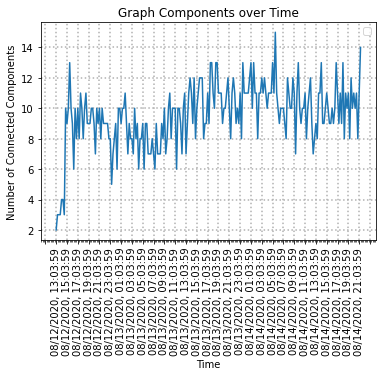

In [20]:
# Components
ig, ax = plt.subplots()

ax.plot(t, components)

ax.set_xlabel('Time')
ax.set_ylabel('Number of Connected Components')
ax.set_title('Graph Components over Time')

plt.xticks(t, time_labels, rotation = 90)
ax.grid(linestyle='dotted', linewidth=1.5)

ax.xaxis.set_major_locator(ticker.MultipleLocator(8))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

ax.legend()
plt.show()

In [20]:
# Density

# Limit Adjustment
density_lim = density[limit:]

# Plot
mpl.use('pdf')
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=10, titlesize=12)
plt.rc('legend', fontsize=10)    

width = 4.1
height = width / 1.618

fig, ax = plt.subplots()
# fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=0.9)
fig.set_size_inches(width, height)

ax.plot(t_lim, density_lim)

ax.set_xlabel("Time")
ax.set_ylabel("Density")
ax.set_title("Graph Density Analysis")

plt.xticks(t_lim, time_labels_lim, rotation = 90)
ax.grid(linestyle='dotted', linewidth=1.5)

ax.xaxis.set_major_locator(ticker.MultipleLocator(16))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

fig.savefig('/home/djuhera/notebooks/plots/density_progression.pdf', bbox_inches = "tight")


#ig, ax = plt.subplots()

#ax.plot(t, density)

#ax.set_xlabel('Time')
#ax.set_ylabel('Graph Density')
#ax.set_title('Graph Density over Time')

#plt.xticks(t, time_labels, rotation = 90)
#ax.grid(linestyle='dotted', linewidth=1.5)

#ax.xaxis.set_major_locator(ticker.MultipleLocator(8))
#ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

#ax.legend()
#plt.show()

In [21]:
# Max Degrees
maximum_degrees = []
for i in range(len(max_degree)):
    degree_vals = (max_degree[i])[0]
    degree_vals = degree_vals[-1]
    maximum_degrees.append(degree_vals)

# Limit Adjustment
maximum_degrees_lim = maximum_degrees[limit:]

# Plot
mpl.use('pdf')
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=10, titlesize=12)
plt.rc('legend', fontsize=10)    

width = 4.1
height = width / 1.618

fig, ax = plt.subplots()
# fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=0.9)
fig.set_size_inches(width, height)

ax.plot(t_lim, maximum_degrees_lim)

ax.set_xlabel("Time")
ax.set_ylabel("Degree")
ax.set_title("Node Degree Analysis")

plt.xticks(t_lim, time_labels_lim, rotation = 90)
ax.grid(linestyle='dotted', linewidth=1.5)

ax.xaxis.set_major_locator(ticker.MultipleLocator(16))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

fig.savefig('/home/djuhera/notebooks/plots/node_degree_progression.pdf', bbox_inches = "tight")

#ig, ax = plt.subplots()

#ax.plot(t, maximum_degrees)

#ax.set_xlabel('Time')
#ax.set_ylabel('Node Degrees')
#ax.set_title('Node Degrees over Time')

#plt.xticks(t, time_labels, rotation = 90)
#ax.grid(linestyle='dotted', linewidth=1.5)

#ax.xaxis.set_major_locator(ticker.MultipleLocator(8))
#ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

#ax.legend()
#plt.show()

In [41]:
# Plot first 3 Hours
limit = time_labels.index('08/12/2020, 15:18:59')
# limit = limit + 5

t_lim = np.arange(limit)
nodes_lim = nodes[:limit]
edges_lim = edges[:limit]
packets_lim = packets[:limit]
traffic_lim = traffic[:limit]
components_lim = components[:limit]
density_lim = density[:limit]
maximum_degrees_lim = maximum_degrees[:limit]
labels_lim = time_labels[:limit]

print("Nodes: ", nodes_lim)
print("Edges: ", edges_lim)
print("Packets: ", packets_lim)
print("Traffic: ", traffic_lim)
print("Components: ", components_lim)
print("Density: ", density_lim)
print("Max Degrees: ", maximum_degrees_lim)
print("Time: ", labels_lim)

nodes_lim = maximum_degrees_lim

# Plot
fig, ax = plt.subplots()

ax.plot(t_lim, nodes_lim)

ax.set_xlabel('Time')
ax.set_ylabel('Number of Nodes')
ax.set_title('Nodes over Time')

plt.xticks(t_lim, labels_lim, rotation = 90)
ax.grid(linestyle='dotted', linewidth=1.5)

#ax.xaxis.set_major_locator(ticker.MultipleLocator(8))
#ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

ax.legend()
plt.show()

No handles with labels found to put in legend.
Nodes:  [17, 43, 40, 40, 53, 53, 55, 737, 1170]
Edges:  [82, 459, 377, 377, 4820, 4895, 9870, 19131, 26028]
Packets:  [7320, 8420, 1100, 1100, 43900, 47115, 101893, 1470529, 2947429]
Traffic:  [680000, 988471, 308471, 308471, 6231915, 6524289, 15091197, 393821770, 1248528753]
Components:  [2, 3, 3, 3, 4, 4, 3, 10, 9]
Density:  [0.3014705882352941, 0.2541528239202658, 0.24166666666666667, 0.24166666666666667, 1.748911465892598, 1.7761248185776488, 3.323232323232323, 0.03526893693587399, 0.019030071724682504]
Max Degrees:  [56, 336, 280, 280, 3776, 3838, 7728, 8761, 7505]
Time:  ['08/12/2020, 13:03:59', '08/12/2020, 13:18:59', '08/12/2020, 13:33:59', '08/12/2020, 13:48:59', '08/12/2020, 14:03:59', '08/12/2020, 14:18:59', '08/12/2020, 14:33:59', '08/12/2020, 14:48:59', '08/12/2020, 15:03:59']


RuntimeError: Failed to process string with tex because latex could not be found